<a href="https://colab.research.google.com/github/dtminnick/pytorch-practice/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook completes the requirements for Deep Learning Module 2

Import libraries.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Load the MNIST data.

Notes:

**transforms.ToTensor()** converts the PIL image to a PyTorch tensor and scales pixel values from [0, 255] to [0.0, 1.0].

**transforms.Normalize((0.5,), (0.5,))** then normalizes the tensor to have values in the range [-1.0, 1.0], assuming the original data is centered around 0.5.

Normalization is applied during data loading.

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Get training data.

training_data = datasets.MNIST(root = "./data",
                            train = True,
                            download = True,
                            transform = transform)

# Get testing data.

testing_data = datasets.MNIST(root = "./data",
                           train = False,
                           download = True,
                           transform = transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.74MB/s]


Confirm download of training data.

In [15]:
print("Training set size:", len(training_data))

Training set size: 50000


Confirm download of test data.

In [16]:
print("Testing set size:", len(testing_data))

Testing set size: 10000


Inspect a small image sample from the training set to confirm normalization was applied properly.

Correct normalization will show pixel values roughly in the range -1.0 to 1.0 and a mean that hovers around 0.0, since I normalized at 0.5.

In [3]:
for i in range(10):
    img_tensor, label = training_data[i]
    print(f"Image {i} - Label: {label}")
    print(f"  Min pixel value: {img_tensor.min().item():.4f}")
    print(f"  Max pixel value: {img_tensor.max().item():.4f}")
    print(f"  Mean pixel value: {img_tensor.mean().item():.4f}")
    print("-" * 40)

Image 0 - Label: 5
  Min pixel value: -1.0000
  Max pixel value: 1.0000
  Mean pixel value: -0.7246
----------------------------------------
Image 1 - Label: 0
  Min pixel value: -1.0000
  Max pixel value: 1.0000
  Mean pixel value: -0.6889
----------------------------------------
Image 2 - Label: 4
  Min pixel value: -1.0000
  Max pixel value: 1.0000
  Mean pixel value: -0.8055
----------------------------------------
Image 3 - Label: 1
  Min pixel value: -1.0000
  Max pixel value: 1.0000
  Mean pixel value: -0.8286
----------------------------------------
Image 4 - Label: 9
  Min pixel value: -1.0000
  Max pixel value: 1.0000
  Mean pixel value: -0.7678
----------------------------------------
Image 5 - Label: 2
  Min pixel value: -1.0000
  Max pixel value: 1.0000
  Mean pixel value: -0.7039
----------------------------------------
Image 6 - Label: 1
  Min pixel value: -1.0000
  Max pixel value: 1.0000
  Mean pixel value: -0.8235
----------------------------------------
Image 7 - Lab

Visualize the sample images alongside their pixel statistics.

Image 0
  Label: 5
  Min: -1.0000
  Max: 1.0000
  Mean: -0.7246
------------------------------
Image 1
  Label: 0
  Min: -1.0000
  Max: 1.0000
  Mean: -0.6889
------------------------------
Image 2
  Label: 4
  Min: -1.0000
  Max: 1.0000
  Mean: -0.8055
------------------------------
Image 3
  Label: 1
  Min: -1.0000
  Max: 1.0000
  Mean: -0.8286
------------------------------
Image 4
  Label: 9
  Min: -1.0000
  Max: 1.0000
  Mean: -0.7678
------------------------------


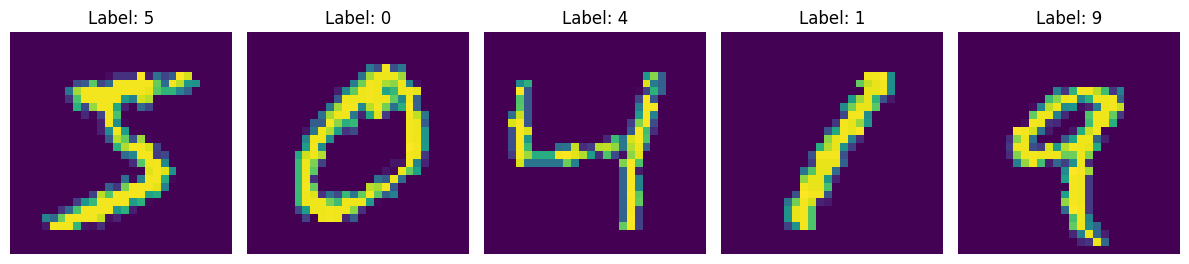

In [7]:
num_samples = 5

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    img_tensor, label = training_data[i]

    # Convert tensor to PIL image for display
    img = to_pil_image(img_tensor)

    # Plot image
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

    # Print pixel stats
    print(f"Image {i}")
    print(f"  Label: {label}")
    print(f"  Min: {img_tensor.min().item():.4f}")
    print(f"  Max: {img_tensor.max().item():.4f}")
    print(f"  Mean: {img_tensor.mean().item():.4f}")
    print("-" * 30)

plt.tight_layout()
plt.show()


Split the data into training, validation and testing sets.

A testing set already exists; randomly take 10,000 images from the training set and reserve them as a validation set.

In [10]:
train_size = 50000
val_size = 10000

training_data, validation_data = random_split(training_data, [train_size, val_size])

Confirm splits.

In [13]:
print("Training set size:", len(training_data))
print("Validation set size:", len(validation_data))
print("Testing set size:", len(testing_data))

Training set size: 50000
Validation set size: 10000
Testing set size: 10000


Build a CNN network with convolution layers, pooling layers to classify the number.

Start by setting a batch size.

Notes on batch size:

Batch size determines how many samples from the dataset are processed together in one forward/backward pass during training.

**Gradient Estimation**

A small batch gives a noisy but fast estimate of the gradient.  And a large batch gives a smoother, more stable gradient but requires more memory to compute.

**Training Speed**

Smaller batches may converge faster in early epochs but can be less stable.  Larger batches can leverage parallelism, speeding up training.

**Generalization**

Smaller batches often introduce more stochasticity, which can help escape local minima and improve generalization.  Larger batches may overfit if not regularized properly.

Start with a batch size of ten and then monitor loss curve stability, validation accuracy and training time per epoch.  If seeing erratic loss or poor generalization, reduce batch size.  If training is slow and memory allows, increase it.

In [17]:
batch_size = 10

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
testing_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

Define two convolutional layers.

One layer that transforms a single-channel image into six feature maps, each capturing different spatial patterns.

Then a second layer that takes the six feature maps from the first layer and extracts deeper, more abstract features into 16 maps.

Note on kernel size and stride parameters:

**Kernel Size**

The kernel is a small matrix that slides over the input image to extract features.  Kernel size defines the dimensions of this matrix, typically 3x3 or 5x5.  It controls the receptive field, i.e. how much of the input the filter sees at once.

**Stride**

Stride controls how far the kernel moves with each step.  A stride of 1 means the kernel moves one pixel at a time.  A stride of 2 skips every other pixel, reducing output size and increasing efficiency.

Varying kernel size and stride can influence the CNN’s loss and accuracy. These parameters shape how the model sees and processes spatial patterns, which directly affects feature extraction and learning dynamics.

Start with a kernel size of 3 and stride of 1.

In [ ]:
conv1 = nn.Conv2d(in_channels = 1,
                  out_channels = 6,
                  kernel_size = 3,
                  stride = 1)

conv2 = nn.Conv2d(in_channels = 6,
                  out_channels = 16,
                  kernel_size=3,
                  stride = 1)

Plot the training loss and validation loss as a function of epochs.

Plot the both training accuracy and validation accuracy as a function of epochs.

Print the testing accuracy.